<a href="https://colab.research.google.com/github/bhanup6663/COMP691_DL/blob/main/Challange1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XGBOOST-Bayesian

In [1]:
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Grayscale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import torch

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

In [3]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:06<00:00, 28086393.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
selected_classes = np.random.choice(range(10), 2, replace=False)

In [5]:
print(selected_classes)

[0 6]


In [6]:
class_mapping = {original: new for new, original in enumerate(selected_classes)}

In [7]:
train_indices = []
test_indices = []

for idx, (image, label) in enumerate(trainset):
    if label in selected_classes:
        train_indices.append(idx)

for idx, (image, label) in enumerate(testset):
    if label in selected_classes:
        test_indices.append(idx)

# Shuffle the indices
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Check if enough samples are found for training and testing
if len(train_indices) < 25 or len(test_indices) < 2000:
    raise ValueError("Insufficient samples found for training or testing.")

In [8]:
train_indices = train_indices[:25]
test_indices = test_indices[:2000]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=25, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
testloader = torch.utils.data.DataLoader(testset, batch_size=2000, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

In [9]:
train_data = []
train_labels = []
test_data = []
test_labels = []

for images, labels in trainloader:
    for image, label in zip(images, labels):
        train_data.append(image.numpy().flatten())
        train_labels.append(label.item())

for images, labels in testloader:
    for image, label in zip(images, labels):
        test_data.append(image.numpy().flatten())
        test_labels.append(label.item())

In [10]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

train_remapped = np.array([class_mapping[label] for label in train_labels])
test_remapped = np.array([class_mapping[label] for label in test_labels])

In [11]:
pca = PCA(n_components=0.70)
X_train_pca = pca.fit_transform(np.array(train_data))
X_test_pca = pca.transform(np.array(test_data))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, np.array(train_remapped), test_size=0.2, stratify=train_remapped)

In [13]:
def objective(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        reg_lambda=space['lambda'],
        objective='multi:softmax',
        eval_metric='mlogloss',
        use_label_encoder=False,
        num_class=2,  # Make sure this is correctly set
        tree_method='gpu_hist',
        device='gpu',  # Updated from gpu_id to device
        seed=42,
        early_stopping_rounds=10  # Moved here as per deprecation warning
    )

    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [14]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 25),  # Widen the range to allow more trees
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7]),  # Narrow down based on typical good performers
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),  # Focus on a range that's typically more effective
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Narrow to focus on higher subsampling rates
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 0.8),  # Adjust to focus on a moderate range
    'lambda': hp.uniform('lambda', 0.5, 2),  # Broaden to explore the impact of regularization more
}


In [15]:
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print(f"Best hyperparameters: {best_hyperparams}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



  2%|▏         | 2/100 [00:00<00:28,  3.38trial/s, best loss: -0.8]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/s

  5%|▌         | 5/100 [00:01<00:14,  6.73trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

  6%|▌         | 6/100 [00:01<00:15,  5.98trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



  8%|▊         | 8/100 [00:01<00:18,  4.90trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 10%|█         | 10/100 [00:01<00:14,  6.25trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 11%|█         | 11/100 [00:02<00:12,  6.85trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 13%|█▎        | 13/100 [00:02<00:15,  5.75trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 16%|█▌        | 16/100 [00:03<00:14,  5.96trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 19%|█▉        | 19/100 [00:03<00:12,  6.51trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 20%|██        | 20/100 [00:03<00:11,  6.98trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 22/100 [00:03<00:11,  6.77trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 24/100 [00:04<00:10,  7.27trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 26/100 [00:04<00:10,  6.95trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 27%|██▋       | 27/100 [00:04<00:13,  5.38trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 29%|██▉       | 29/100 [00:05<00:13,  5.38trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 30%|███       | 30/100 [00:05<00:14,  4.97trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 32/100 [00:05<00:15,  4.26trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 34/100 [00:06<00:13,  4.72trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 36/100 [00:06<00:12,  5.31trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 37%|███▋      | 37/100 [00:06<00:12,  5.24trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 38/100 [00:06<00:10,  5.71trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 39%|███▉      | 39/100 [00:07<00:14,  4.29trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 41%|████      | 41/100 [00:07<00:12,  4.84trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 42/100 [00:07<00:10,  5.31trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 45/100 [00:08<00:08,  6.29trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 46/100 [00:08<00:11,  4.82trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 47%|████▋     | 47/100 [00:08<00:11,  4.61trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 49%|████▉     | 49/100 [00:09<00:10,  4.69trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 51%|█████     | 51/100 [00:09<00:08,  5.72trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 53%|█████▎    | 53/100 [00:09<00:07,  6.53trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 55%|█████▌    | 55/100 [00:09<00:05,  7.94trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 57%|█████▋    | 57/100 [00:10<00:08,  5.08trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 58%|█████▊    | 58/100 [00:10<00:08,  5.18trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 60%|██████    | 60/100 [00:11<00:06,  6.11trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 61%|██████    | 61/100 [00:11<00:07,  5.55trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 62%|██████▏   | 62/100 [00:11<00:08,  4.60trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 64%|██████▍   | 64/100 [00:12<00:08,  4.43trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 66%|██████▌   | 66/100 [00:12<00:05,  5.89trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 68%|██████▊   | 68/100 [00:12<00:04,  6.47trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 69%|██████▉   | 69/100 [00:12<00:04,  6.35trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 71%|███████   | 71/100 [00:13<00:04,  5.86trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 73%|███████▎  | 73/100 [00:13<00:03,  7.04trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 75/100 [00:13<00:04,  6.00trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 76%|███████▌  | 76/100 [00:13<00:04,  5.49trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 77%|███████▋  | 77/100 [00:14<00:03,  6.18trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 79%|███████▉  | 79/100 [00:14<00:03,  5.87trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 81%|████████  | 81/100 [00:14<00:02,  6.46trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 83%|████████▎ | 83/100 [00:14<00:02,  6.95trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 85/100 [00:15<00:02,  6.97trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 86%|████████▌ | 86/100 [00:15<00:02,  6.02trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 88%|████████▊ | 88/100 [00:15<00:02,  5.45trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 90%|█████████ | 90/100 [00:16<00:01,  5.57trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 91%|█████████ | 91/100 [00:16<00:01,  5.81trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 92%|█████████▏| 92/100 [00:16<00:01,  4.08trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 94%|█████████▍| 94/100 [00:17<00:01,  3.79trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 95/100 [00:17<00:01,  4.49trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 96%|█████████▌| 96/100 [00:17<00:00,  4.85trial/s, best loss: -1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

100%|██████████| 100/100 [00:18<00:00,  5.53trial/s, best loss: -1.0]
Best hyperparameters: {'colsample_bytree': 0.4545988285613425, 'lambda': 0.6241402514502195, 'learning_rate': 0.06071096159282887, 'max_depth': 2, 'n_estimators': 175.0, 'subsample': 0.5466893366576624}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



In [16]:
best_n_estimators = int(best_hyperparams['n_estimators'])
best_max_depth = int(best_hyperparams['max_depth'])
best_learning_rate = best_hyperparams['learning_rate']
best_subsample = best_hyperparams['subsample']
best_colsample_bytree = best_hyperparams['colsample_bytree']
best_lambda = best_hyperparams['lambda']

In [17]:
trained_model = XGBClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_lambda=best_lambda,
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    num_class=2,  # Assuming binary or two-class classification
    tree_method='gpu_hist',
    device='gpu',  # Or 'cpu' if not using GPU
    seed=42
)


In [18]:
trained_model.fit(X_train_pca, train_remapped)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4545988285613425, device='gpu',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06071096159282887,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=175, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [19]:
predictions = trained_model.predict(X_test_pca)

In [20]:
XGBoost_accuracy = accuracy_score(test_remapped, predictions)
print(f'XGBoost Test Accuracy: {XGBoost_accuracy*100:.2f}%')

XGBoost Test Accuracy: 79.70%


SVM

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset

In [26]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Define transformations for training and validation data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [27]:
num_classes = 2
num_samples_per_class = 25

# Load CIFAR-10 dataset
cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

selected_indices_train = []
selected_indices_val = []

# Select samples for training and validation
for i in selected_classes:
    class_indices = np.where(np.array(cifar_data.targets) == i)[0]
    selected_indices_train.extend(np.random.choice(class_indices, num_samples_per_class, replace=False))
    remaining_indices = list(set(class_indices) - set(selected_indices_train))
    selected_indices_val.extend(remaining_indices)

Files already downloaded and verified


In [28]:
# Create Subset datasets for training and validation
train_data = Subset(cifar_data, selected_indices_train)
val_data = Subset(cifar_data, selected_indices_val)

# Create DataLoader for training and validation datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), shuffle=False)

# Extract features and labels from training and validation datasets
train_features, train_labels = next(iter(train_loader))
val_features, val_labels = next(iter(val_loader))

train_features = train_features.view(train_features.size(0), -1).numpy()
val_features = val_features.view(val_features.size(0), -1).numpy()

# Normalize features using StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

In [29]:
hyperparameters = [
    {'C': 0.5, 'gamma': 'scale', 'random_seed': 2},
    {'C': 1.0, 'gamma': 'scale', 'random_seed': 1},
    {'C': 2.0, 'gamma': 'scale', 'random_seed': 2},
    {'C': 3.0, 'gamma': 'scale', 'random_seed': 1},
    {'C': 0.5, 'gamma': 'scale', 'random_seed': 1},
    {'C': 1.0, 'gamma': 'auto', 'random_seed': 2},
    {'C': 2.0, 'gamma': 'auto', 'random_seed': 1},
    {'C': 3.0, 'gamma': 'auto', 'random_seed': 2},
]


In [30]:
# Train SVM models with different hyperparameters
svm_models = []
svm_accuracies = []
for params in hyperparameters:
    # Initialize SVM model with specified hyperparameters
    model = SVC(kernel='rbf', C=params['C'], gamma=params['gamma'], random_state=params['random_seed'])

    # Train model
    model.fit(train_features_scaled, train_labels)

    # Add trained model to list
    svm_models.append(model)

    # Predict on validation set
    val_predictions = model.predict(val_features_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(val_labels, val_predictions)
    print("Taken Parameters: {}".format(params))
    print("Accuracy: {}".format(accuracy))
    svm_accuracies.append(accuracy)

# Find the best hyperparameter combination and its accuracy
best_idx = np.argmax(svm_accuracies)
best_hyperparams = hyperparameters[best_idx]
best_accuracy = svm_accuracies[best_idx]

print("Best Hyperparameters:")
print(best_hyperparams)
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

Taken Parameters: {'C': 0.5, 'gamma': 'scale', 'random_seed': 2}
Accuracy: 0.7530653266331658
Taken Parameters: {'C': 1.0, 'gamma': 'scale', 'random_seed': 1}
Accuracy: 0.7839195979899497
Taken Parameters: {'C': 2.0, 'gamma': 'scale', 'random_seed': 2}
Accuracy: 0.7962814070351759
Taken Parameters: {'C': 3.0, 'gamma': 'scale', 'random_seed': 1}
Accuracy: 0.79356783919598
Taken Parameters: {'C': 0.5, 'gamma': 'scale', 'random_seed': 1}
Accuracy: 0.7530653266331658
Taken Parameters: {'C': 1.0, 'gamma': 'auto', 'random_seed': 2}
Accuracy: 0.7839195979899497
Taken Parameters: {'C': 2.0, 'gamma': 'auto', 'random_seed': 1}
Accuracy: 0.7962814070351759
Taken Parameters: {'C': 3.0, 'gamma': 'auto', 'random_seed': 2}
Accuracy: 0.79356783919598
Best Hyperparameters:
{'C': 2.0, 'gamma': 'scale', 'random_seed': 2}
Best Accuracy: 79.63%


In [31]:
# Predictions from individual SVM models
individual_predictions = [model.predict(val_features_scaled) for model in svm_models]

# Ensemble predictions by averaging
ensemble_predictions_avg = np.mean(individual_predictions, axis=0)

# Ensemble predictions by voting
ensemble_predictions_vote = np.round(np.mean(individual_predictions, axis=0))

# Convert ensemble predictions to discrete values (0 or 1)
ensemble_predictions_avg_discrete = np.round(ensemble_predictions_avg)
ensemble_predictions_vote_discrete = np.round(ensemble_predictions_vote)

# Calculate accuracy for ensemble predictions
accuracy_avg_discrete = accuracy_score(val_labels, ensemble_predictions_avg_discrete)
SVM_accuracy_vote_discrete = accuracy_score(val_labels, ensemble_predictions_vote_discrete)

print("Ensemble Accuracy (Averaging) after conversion: {:.2f}%".format(accuracy_avg_discrete * 100))
print("Ensemble Accuracy (Voting) after conversion: {:.2f}%".format(SVM_accuracy_vote_discrete * 100))

Ensemble Accuracy (Averaging) after conversion: 72.38%
Ensemble Accuracy (Voting) after conversion: 72.38%


Custom CNN

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, Subset, random_split
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [34]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

In [35]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [37]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [38]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [39]:
best_val_accuracy = 0
best_model_weights = None

In [40]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [41]:
def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [42]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(trainset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]

    N = 25
    class_counts = {label: 0 for label in selected_classes}
    filtered_train_indices = []

    for i in train_indices:
        _, label = trainset[i]
        if class_counts[label] < N:
            filtered_train_indices.append(i)
            class_counts[label] += 1


    np.random.seed(42)
    np.random.shuffle(filtered_train_indices)
    split = int(0.8 * len(filtered_train_indices))
    train_idx, val_idx = filtered_train_indices[:split], filtered_train_indices[split:]

    train_subset = Subset(trainset, train_idx)
    transformed_train_subset = TransformSubset(train_subset, transform=train_transform)

    val_subset = Subset(trainset, val_idx)
    transformed_val_subset = TransformSubset(val_subset, transform=test_transform)

    train_loader = DataLoader(transformed_train_subset, batch_size=5, shuffle=True)
    val_loader = DataLoader(transformed_val_subset, batch_size=5, shuffle=False)


    # Init the neural network
    model = CustomCNN().to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.005)
    criterion = nn.CrossEntropyLoss()

    # Initilization of scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25


    # Run the training loop for defined number of epochs
    num_epochs = 50
    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Perform training and validation
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate(model, device, val_loader, criterion)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Save the model if it has the best val accuracy so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
             # Save the best model weights
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            # Stop training if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    print('--------------------------------')

# Save the best model weights
torch.save(best_model_weights, 'CNN_best_model.pth')
print(f'Best validation accuracy of {best_val_accuracy:.2f}% achieved, model saved as CNN_best_model.pth')

FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Starting epoch 1
Train Loss: 1.6392, Train Acc: 45.00%, Val Loss: 6.6432, Val Acc: 70.00%
Starting epoch 2
Train Loss: 1.3654, Train Acc: 57.50%, Val Loss: 4.9183, Val Acc: 50.00%
Starting epoch 3
Train Loss: 1.5111, Train Acc: 57.50%, Val Loss: 2.6562, Val Acc: 50.00%
Starting epoch 4
Train Loss: 1.7141, Train Acc: 60.00%, Val Loss: 1.9212, Val Acc: 30.00%
Starting epoch 5
Train Loss: 0.9353, Train Acc: 52.50%, Val Loss: 0.4701, Val Acc: 80.00%
Starting epoch 6
Train Loss: 1.1356, Train Acc: 47.50%, Val Loss: 0.4933, Val Acc: 70.00%
Starting epoch 7
Train Loss: 0.6907, Train Acc: 70.00%, Val Loss: 0.9504, Val Acc: 60.00%
Starting epoch 8
Train Loss: 0.6925, Train Acc: 65.00%, Val Loss: 0.7055, Val Acc: 60.00%
Starting epoch 9
Train Loss: 0.7149, Train Acc: 67.50%, Val Loss: 0.9551, Val Acc: 60.00%
Starting epoch 10
Train Loss: 0.5995, Train Acc: 77.50%, Val Loss: 0.8368, Val Acc: 60.00%
Starting epoch 11
Train Loss: 0.7980, Train Acc: 67.50%, Val Loss: 0.8053, Val Acc: 60.00%
Starting

In [43]:
model = CustomCNN().to(device)
model.load_state_dict(torch.load('CNN_best_model.pth'))

<All keys matched successfully>

In [44]:
test_indices = [i for i, (_, label) in enumerate(testset) if label in selected_classes]
N = 1000
class_counts = {label: 0 for label in selected_classes}
filtered_train_indices = []

for i in test_indices:
    _, label = testset[i]
    if class_counts[label] < N:
        filtered_train_indices.append(i)
        class_counts[label] += 1

test_subset = Subset(testset, filtered_train_indices)
test_loader = DataLoader(test_subset, batch_size=50, shuffle=False)

In [45]:
# Ensure the model is in evaluation mode
model.eval()

# Assuming the test_loader and the device are already defined
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluation
test_loss = 0
correct = 0
total = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for data, targets in test_loader:
        # Move data and targets to the correct device
        data = data.to(device)
        targets = targets.to(device)

        # Compute the model output
        output = model(data)
        loss = criterion(output, targets)

        # Accumulate the loss and calculate accuracy
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate average loss and accuracy percentage
Custom_CNN_avg_loss = test_loss / len(test_loader)
Custom_CNN_accuracy = 100. * correct / total

# Print the test loss and accuracy
print(f'Test Loss: {Custom_CNN_avg_loss:.4f}, Test Accuracy: {Custom_CNN_accuracy:.2f}%')


Test Loss: 0.3441, Test Accuracy: 86.05%


VIT

In [46]:
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

In [47]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

In [48]:
model = models.vit_b_16(pretrained=False)

num_classes = 10
dropout_rate = 0.5

model.heads = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(model.heads[0].in_features, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [49]:
best_val_accuracy = 0
best_model_weights = None

In [50]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(trainset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]

    N = 25
    class_counts = {label: 0 for label in selected_classes}
    filtered_train_indices = []

    for i in train_indices:
        _, label = trainset[i]
        if class_counts[label] < N:
            filtered_train_indices.append(i)
            class_counts[label] += 1


    np.random.seed(42)
    np.random.shuffle(filtered_train_indices)
    split = int(0.8 * len(filtered_train_indices))
    train_idx, val_idx = filtered_train_indices[:split], filtered_train_indices[split:]

    train_subset = Subset(trainset, train_idx)
    transformed_train_subset = TransformSubset(train_subset, transform=train_transform)

    val_subset = Subset(trainset, val_idx)
    transformed_val_subset = TransformSubset(val_subset, transform=test_transform)

    train_loader = DataLoader(transformed_train_subset, batch_size=5, shuffle=True)
    val_loader = DataLoader(transformed_val_subset, batch_size=5, shuffle=False)


    # Init the neural network
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25


    # Run the training loop for defined number of epochs
    num_epochs = 50
    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Perform training and validation
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate(model, device, val_loader, criterion)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Save the model if it has the best val accuracy so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()  # Save the best model weights
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break  # Stop training if no improvement

        # Step the learning rate scheduler
        scheduler.step()

    print('--------------------------------')

# Save the best model weights
torch.save(best_model_weights, 'VIT_best_model.pth')
print(f'Best validation accuracy of {best_val_accuracy:.2f}% achieved, model saved as VIT_best_model.pth')

FOLD 0
--------------------------------
Starting epoch 1
Train Loss: 1.7342, Train Acc: 45.00%, Val Loss: 0.5150, Val Acc: 80.00%
Starting epoch 2
Train Loss: 0.8953, Train Acc: 75.00%, Val Loss: 1.3709, Val Acc: 60.00%
Starting epoch 3
Train Loss: 0.6972, Train Acc: 75.00%, Val Loss: 0.8361, Val Acc: 80.00%
Starting epoch 4
Train Loss: 0.5429, Train Acc: 77.50%, Val Loss: 0.5366, Val Acc: 90.00%
Starting epoch 5
Train Loss: 0.4767, Train Acc: 75.00%, Val Loss: 0.7198, Val Acc: 70.00%
Starting epoch 6
Train Loss: 0.3835, Train Acc: 87.50%, Val Loss: 0.5894, Val Acc: 70.00%
Starting epoch 7
Train Loss: 0.4077, Train Acc: 87.50%, Val Loss: 0.5540, Val Acc: 70.00%
Starting epoch 8
Train Loss: 0.4136, Train Acc: 80.00%, Val Loss: 0.6259, Val Acc: 70.00%
Starting epoch 9
Train Loss: 0.4256, Train Acc: 85.00%, Val Loss: 0.4823, Val Acc: 90.00%
Starting epoch 10
Train Loss: 0.3953, Train Acc: 87.50%, Val Loss: 0.7291, Val Acc: 70.00%
Starting epoch 11
Train Loss: 0.4295, Train Acc: 80.00%, Va

In [51]:
model = model.to(device)
model.load_state_dict(torch.load('VIT_best_model.pth'))

<All keys matched successfully>

In [52]:
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [53]:
test_indices = [i for i, (_, label) in enumerate(testset) if label in selected_classes]
N = 1000
class_counts = {label: 0 for label in selected_classes}
filtered_train_indices = []

for i in test_indices:
    _, label = testset[i]
    if class_counts[label] < N:
        filtered_train_indices.append(i)
        class_counts[label] += 1

test_subset = Subset(testset, filtered_train_indices)
test_loader = DataLoader(test_subset, batch_size=50, shuffle=False)

In [54]:
# Ensure the model is in evaluation mode
model.eval()

# Assuming the test_loader and the device are already defined
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluation
test_loss = 0
correct = 0
total = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for data, targets in test_loader:
        # Move data and targets to the correct device
        data = data.to(device)
        targets = targets.to(device)

        # Compute the model output
        output = model(data)
        loss = criterion(output, targets)

        # Accumulate the loss and calculate accuracy
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate average loss and accuracy percentage
VIT_avg_loss = test_loss / len(test_loader)
VIT_accuracy = 100. * correct / total

# Print the test loss and accuracy
print(f'Test Loss: {VIT_avg_loss:.4f}, Test Accuracy: {VIT_accuracy:.2f}%')


Test Loss: 0.7818, Test Accuracy: 86.50%


Graphs

In [55]:
selected_classes_mapping = {0: "Cat", 1: "Dog", 2: "Bird", 3: "Horse", 4: "Ship", 5: "Truck", 6: "Frog", 7: "Airplane", 8: "Deer", 9: "Automobile"}
selected_classes = [selected_classes_mapping[class_num] for class_num in selected_classes]
print(f'Randomly selected from CIFAR-10 are {selected_classes}')

Randomly selected from CIFAR-10 are ['Cat', 'Frog']


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

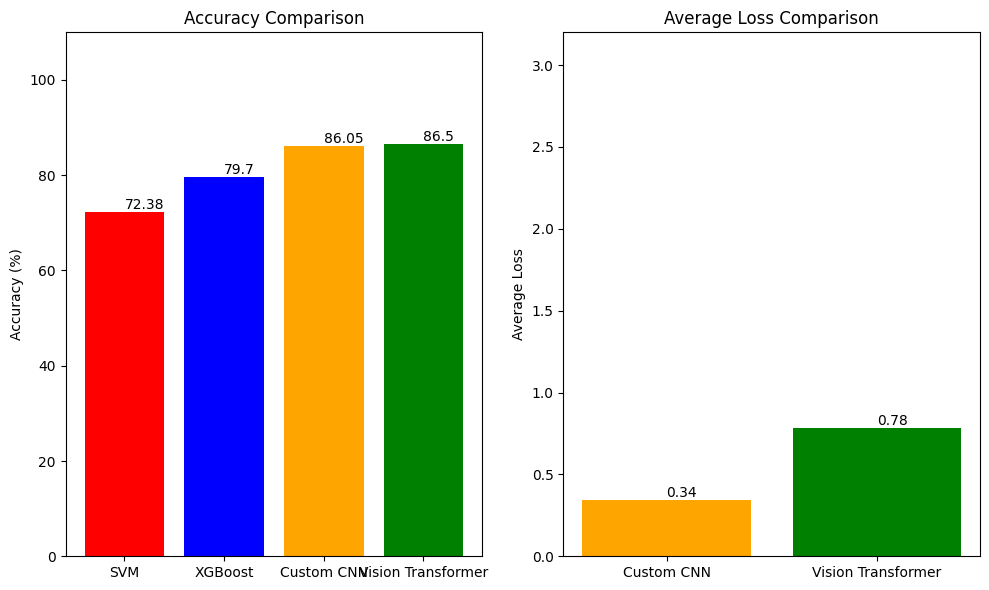

In [61]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(['SVM','XGBoost', 'Custom CNN', 'Vision Transformer'], [SVM_accuracy_vote_discrete*100,XGBoost_accuracy * 100, Custom_CNN_accuracy, VIT_accuracy], color=['red','blue', 'orange', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

# Loss comparison
plt.subplot(1, 2, 2)
bars = plt.bar(['Custom CNN', 'Vision Transformer'], [Custom_CNN_avg_loss, VIT_avg_loss], color=['orange', 'green'])
plt.title('Average Loss Comparison')
plt.ylabel('Average Loss')
plt.ylim(0, 3.2)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()